In [1]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
legend_fontsize = 16

# Часть 1 - О теореме Байеса

Первая часть состоит из двух вопросов и одного задания. Смысл её в том, чтобы провести вероятностные рассуждения в ситуациях, когда модель сама по себе очень простая, но её ещё надо правильно построить, правильно отобразить жизненную ситуацию. Поэтому на первые два вопроса рекомендую давать развёрнутые ответы; эти ответы лучше писать прямо в ноутбуке, LaTeX в jupyter работает на вполне достаточном для нас уровне.

## Часть 1.1

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови!
Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

Обозначим за:

- $p(k)$ - вероятность что подозреваемый убийца
- $p(!k)$ - вероятность что подозреваемый невиновен
- $p(b) = 0.01$ - вероятность иметь редкую группу крови
- $p(b|k) = 1$ - вероятность иметь редкую группу крови при условии убийства, она равна 1 поскольку достоверно известно что убийца имел редкую группу крови
- $p(k|b)$ - вероятность что подозреваемый убийца, при редкой группе крови
- $p(!k|b)$ - вероятность что подозреваемый невиновен, при редкой группе крови

Посчитаем вероятность иметь редкую группу крови если подозреваемый невиновен

$$p(b|!k) = \frac{p(!k|b) * p(b)}{p(!k)} = \frac{p(!k|b) * 0.01}{p(!k)}$$

Учитывая что прокорур дает оценку невиновсти равной 0.01 при редкой группе крови, тогда:

- $p(!k) \approx 1$
- $p(!k|b) \approx 1$
- $p(b|!k) = 0.01$

И ими можно принебречь

Иначе $\frac{p(!k|b)}{p(!k)} < 1$ и вероятность иметь такую группу крови при невиновности становится меньше

Однако ошибка прокурора заключается в том что он предполагает, что: $p(k|b) = 1 - p(b|!k)$

Хотя $1 - p(b|!k) = p(!b|!k)$ - дает вероятность иметь другую группу крови при условии невиновности

Для данных вычислений прокурору следовало оценить $p(!k|b)$ и тогда $1 - p(!k|b) = p(k|b)$ дало бы корректный ответ

## Часть 1.2

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

Нам необходимо оценить вероятность подозреваемому быть убийцей, при совпадении группы крови:

$$p(k|b) = \frac{p(b|k) * p(k)}{p(b)}$$

Где:

- $p(k|b)$ - вероятность убийства случайным человеком при совпадающей группе крови
- $p(b|k) = 1$ - вероятность *случайному* человеку иметь группу при условии убийства
- $p(b) = 0.01$ - вероятность иметь группу крови *случайным* человеком
- $p(k)$ - вероятность подозреваемому быть убийцей, в данном множителе адвокат допустил ошибку

Вместо оценки 1/кол-во подозреваемых адвокат дал оценку 1/кол-во людей с такой группой крови

## Часть 1.3

Вернёмся к тесту на страшную болезнь из первой лекции. Напомню, что по предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны. Мы видели, что в результате человек с положительным тестом имеет апостериорную вероятность оказаться больным всего лишь около 16%.
Врачи решили, что терпеть это никак нельзя; они готовы провести срочное исследование и улучшить качество теста. Но сил и денег хватит только для того, чтобы сократить один тип ошибок, т.е. уменьшить или только число false positives (когда тест выдаёт положительный результат у здорового человека), или только число false negatives (когда тест выдаёт отрицательный результат у больного).
Помогите медикам: постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?


In [3]:
sick = 0.01 # процент больных людей
fp = 0.05 # false positive rate
fn = 0.05 # false negative rate
tp = 1 - fn # true positive rate
tn = 1 - fp # true negative rate

In [4]:
def posterior_sick(fp = 0.05, fn = 0.05):
    """
    Функция подсчета апосториорной вероятности болезни
    при условии положительного теста
    p(sick|positive) = p(positive|sick) * p(sick) / p(positive)
    :param fp - вероятность ложноположительного теста
    :param fn - вероятность ложноотрицательного теста
    :return - апостриорную вероятность болезни
    """
    tp = 1 - fn
    return tp * sick / (tp * sick + fp * (1 - sick))

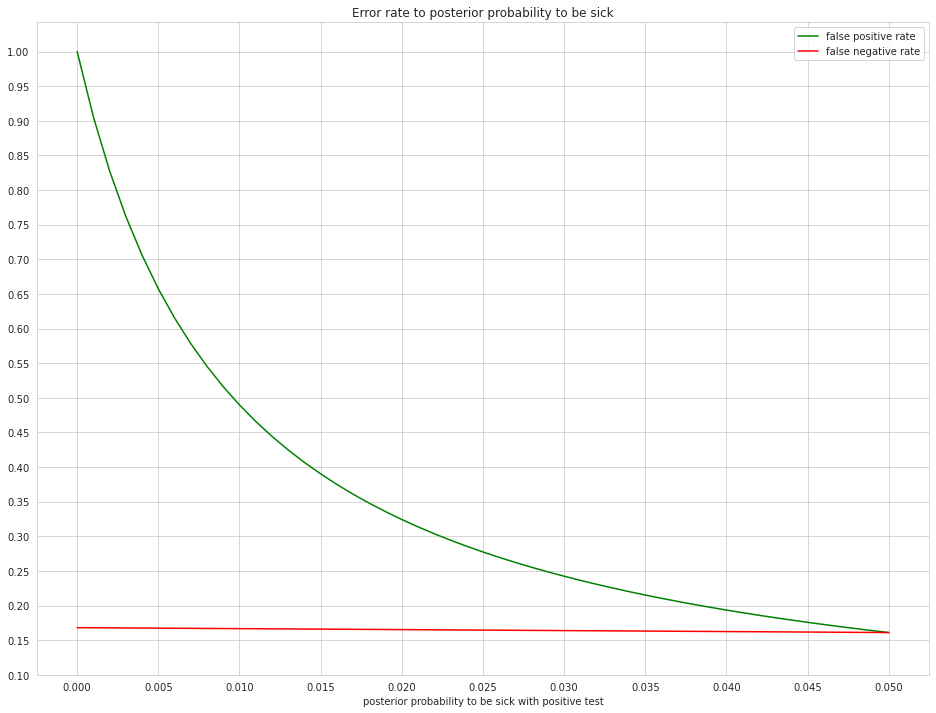

In [5]:
x = np.linspace(0.00, 0.05, 51)

plt.figure(figsize=(16, 12));
plt.plot(x, posterior_sick(fp=x), label="false positive rate", color="g");
plt.plot(x, posterior_sick(fn=x), label="false negative rate", color="r");
plt.xlabel("error rate");
plt.xlabel("posterior probability to be sick with positive test");
plt.title("Error rate to posterior probability to be sick");
plt.grid(True);
plt.xticks(np.arange(0, 0.055, 0.005));
plt.yticks(np.arange(0.1, 1.05, 0.05));
plt.legend(loc="best");

Рассмотрим графики вероятности быть больным при разных ошибках. Исходя из графика видно что лучше сосредоточится на уменьшении false positive ошибок, что довольно логично ибо эта ошибка вносит вклад только в знаменателе, при умножении на большее число (0,99). В то время как false negative увеличивает true positive с 0.95 до 1 и в числителе и в знаменателе

In [6]:
def posterior_health(fp = 0.05, fn = 0.05):
    """
    Функция подсчета апосториорной вероятности быть здоровым
    при условии отрицательного теста
    p(health|negative) = p(negative|health) * p(health) / p(negative)
    :param fp - вероятность ложноположительного теста
    :param fn - вероятность ложноотрицательного теста
    :return - апостриорную вероятность болезни
    """
    tn = 1 - fp
    return tn * (1 - sick) / (fn * sick + tn * (1 - sick))

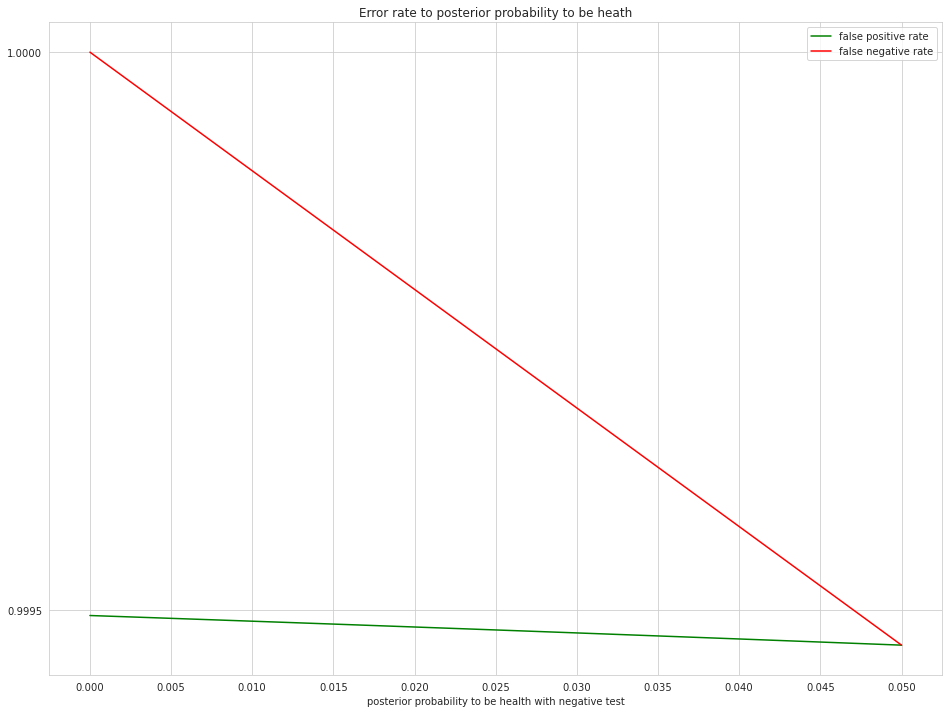

In [7]:
x = np.linspace(0.00, 0.05, 51)

plt.figure(figsize=(16, 12));
plt.plot(x, posterior_health(fp=x), label="false positive rate", color="g");
plt.plot(x, posterior_health(fn=x), label="false negative rate", color="r");
plt.xlabel("error rate");
plt.xlabel("posterior probability to be health with negative test");
plt.title("Error rate to posterior probability to be heath");
plt.grid(True);
plt.xticks(np.arange(0, 0.055, 0.005));
plt.yticks(np.arange(0.9995, 1.0005, 0.0005));
plt.legend(loc="best");

Рассмотрим графики быть здоровым при разных ошибках. Исходя из графика видно что лучше сосредоточится на уменьшении false negative ошибок.

Ответы разнятся и хотя суммарная ошибка при уменьшии false positive rate значительно меньше, но мы бы хотели достоверно знать что человек здоров. Однако мы можем провести несколько тестов и учитывать общий результат, давайте посчитаем какими будут ошибки теста при разных количествах

In [8]:
def posterior_sick_mult(fp = 0.05, fn = 0.05, n = 2):
    """
    Функция подсчета апосториорной вероятности болезни
    при условии нескольких положительных тестов
    :param fp - вероятность ложноположительного теста
    :param fn - вероятность ложноотрицательного теста
    :return - апостриорную вероятность болезни
    """
    
    return 1 - (1 - posterior_sick(fp=fp, fn=fn)) ** n

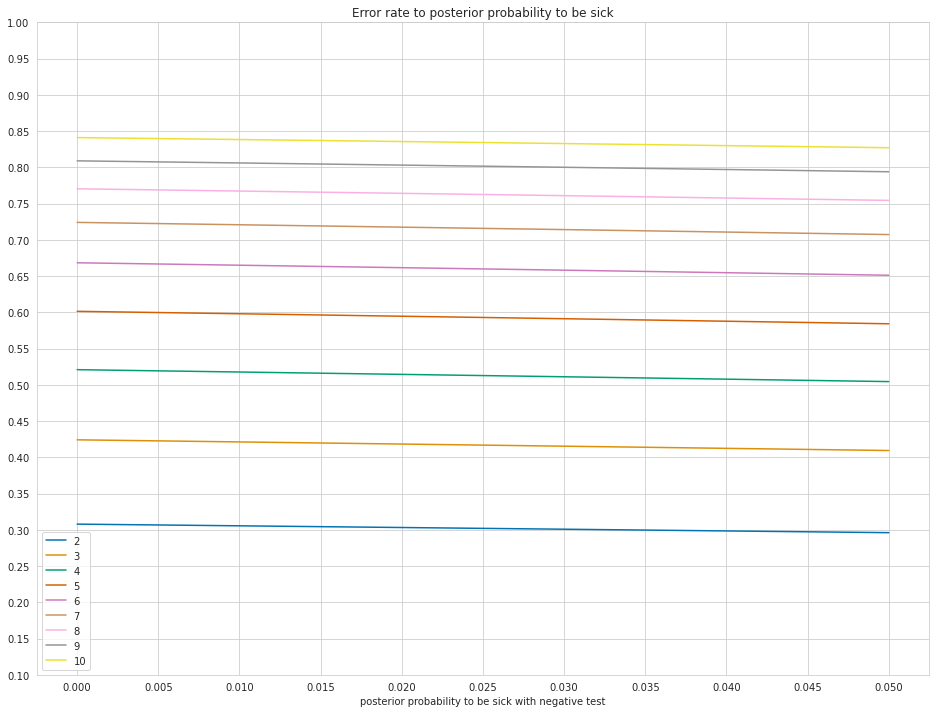

In [9]:
x = np.linspace(0.00, 0.05, 51)

plt.figure(figsize=(16, 12));
for n in range(2, 11):
    plt.plot(x, posterior_sick_mult(fn=x, n=n), label=f"{n}");
plt.xlabel("error rate");
plt.xlabel("posterior probability to be sick with negative test");
plt.title("Error rate to posterior probability to be sick");
plt.grid(True);
plt.xticks(np.arange(0, 0.055, 0.005));
plt.yticks(np.arange(0.1, 1.05, 0.05));
plt.legend(loc="best");

Наращивая количество тестов на человека мы можем достичь достаточно высокой вероятности что человек болен, когда один из тестов положителен

# Часть 2: О линейной регрессии
Эта часть первого домашнего задания связана с анализом конкретного датасета. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

## Часть 2.1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). 

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. 

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). 

Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [10]:
START_DATE = datetime(2020, 3, 3)
MAY_FIRST = (datetime(2020, 5, 1) - START_DATE).days
JUNE_FIRST = (datetime(2020, 6, 1) - START_DATE).days
SEPTEMBER_FIRST = (datetime(2020, 9, 1) - START_DATE).days

In [11]:
df = pd.read_csv("data/owid-covid-data.csv")

In [12]:
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [13]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [14]:
df["y"] = df["total_cases"]
df["x"] = (df["date"] - START_DATE).dt.days

In [15]:
russia_df = df[df["location"] == "Russia"].reset_index(drop=True)

In [16]:
train_df = russia_df[russia_df["date"] >= START_DATE].iloc[:50].reset_index(drop=True)
test_df = russia_df[russia_df["date"] >= START_DATE].iloc[50:].reset_index(drop=True)

## Часть 2.2

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. 

Для первого подхода к снаряду давайте это и используем.

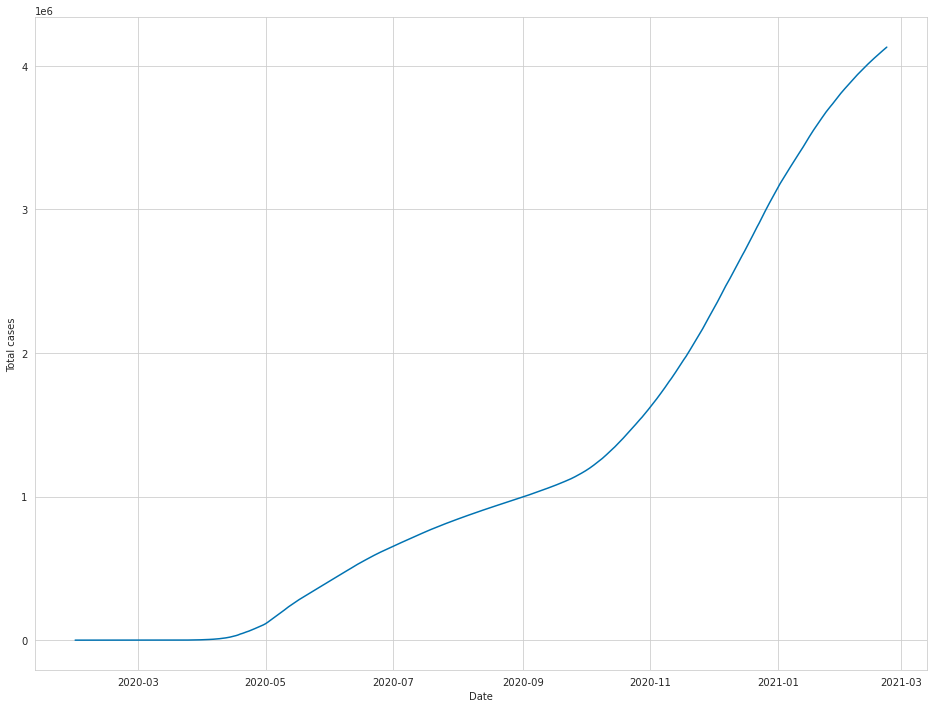

In [17]:
plt.figure(figsize=(16, 12));
plt.plot(russia_df["date"], russia_df["y"]);
plt.grid(True);
plt.xlabel("Date");
plt.ylabel("Total cases");

### Часть 2.2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Исходя из нашего предположения

$$\large{y \sim e^{kx + b}}$$

Тогда:

$$\large{log(y) \sim log(e^{kx + b}) = kx + b}$$

Будем обучать модель с одним признаком - номер дня, предсказывать логарифм целевой переменной

In [18]:
est = LinearRegression()

In [19]:
est.fit(train_df["x"].values.reshape(-1, 1), np.log(train_df["y"]))

LinearRegression()

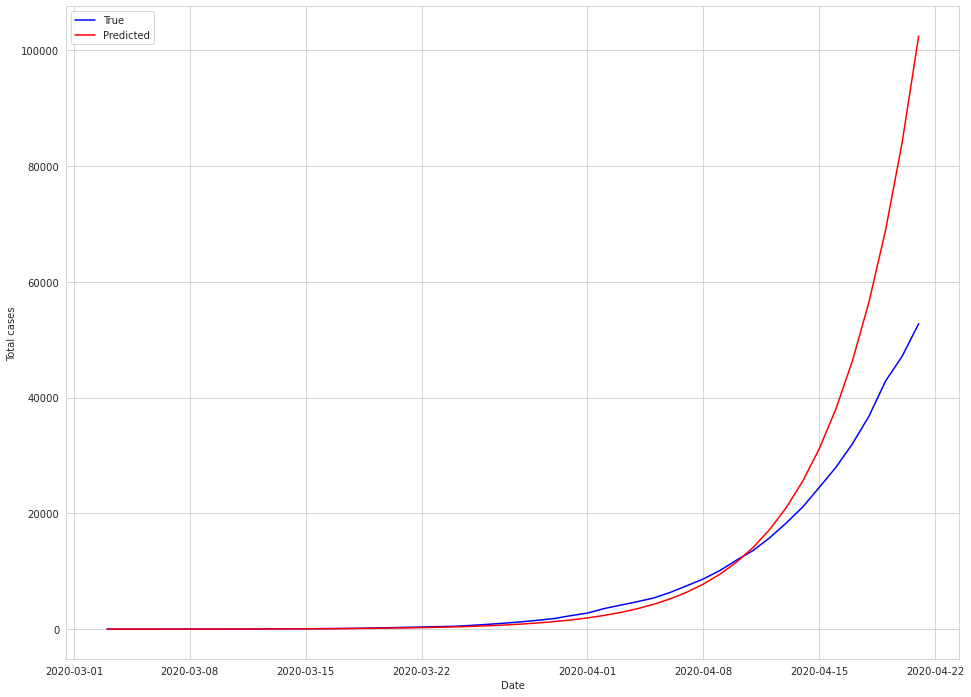

In [20]:
pred = est.predict(train_df["x"].values.reshape(-1, 1))

plt.figure(figsize=(16, 12));
plt.plot(
    train_df["date"], 
    train_df["y"],
    color="b",
    label="True"
);
plt.plot(
    train_df["date"], 
    np.exp(pred), 
    color="r",
    label="Predicted"
);
plt.legend(loc="best");
plt.grid(True);
plt.xlabel("Date");
plt.ylabel("Total cases");

### Часть 2.2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. 

Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).


Натренеруем гребневую регрессию и оценим:

Оценим дисперсию шума данных

$$\large{\sigma^2 = \frac{1}{N} \sum_{n=1}^{N} (y_n - w^T\Phi(x_n))^2}$$

In [21]:
pred = est.predict(train_df["x"].values.reshape(-1, 1))
sigma_noise = np.mean((np.log(train_df["y"]) - pred)**2)

Посчитаем параметры апостреирного распредления весов модели

$$\large{\mu_N = \Sigma_N (\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}\Phi^Tt)}$$
$$\large{\Sigma_N = (\Sigma_0^{-1} + \frac{1}{\sigma^2}\Phi^T\Phi)^{-1}}$$

In [22]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [23]:
x_matrix = np.column_stack([np.ones(train_df.shape[0]), train_df["x"]])

mu, sigma = bayesian_update(
    np.zeros(2),
    10**3 * np.eye(2), 
    x_matrix,
    np.log(train_df["y"]).values, 
    sigma_noise
)

In [24]:
print(f"Mean of W:\n{mu}")
print(f"Variance of W:\n{sigma}")

Mean of W:
[1.82073506 0.19829098]
Variance of W:
[[ 1.15248767e-03 -3.49238688e-05]
 [-3.49238688e-05  1.42546446e-06]]


### Часть 2.2.c

Посэмплируйте много разных экспонент, постройте графики. 

Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? 

Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [25]:
n_samples = 200
w = np.random.multivariate_normal(mu, sigma, n_samples)

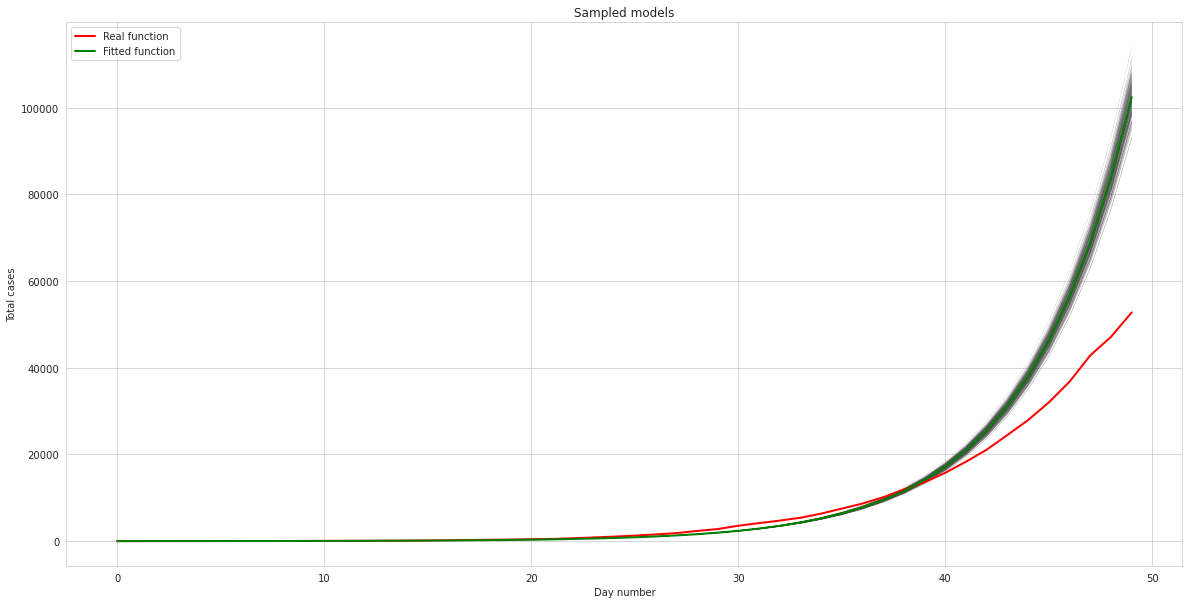

In [26]:
plt.figure(figsize=(20, 10));
for i in range(n_samples):
    plt.plot(train_df["x"], np.exp(x_matrix.dot(w[i])), linewidth=.1, color="0.3");
plt.plot(train_df["x"], train_df["y"], label="Real function", c="r", linewidth=2);
plt.plot(train_df["x"], np.exp(pred), label="Fitted function", c="g", linewidth=2);
plt.xlabel("Day number");
plt.ylabel("Total cases");
plt.title("Sampled models");
plt.legend(loc="best");

In [27]:
x = pd.Series([
    MAY_FIRST,
    JUNE_FIRST,
    SEPTEMBER_FIRST
])

pred_matrix = np.column_stack([np.ones(3), x])

res = np.exp(w.dot(pred_matrix.T))

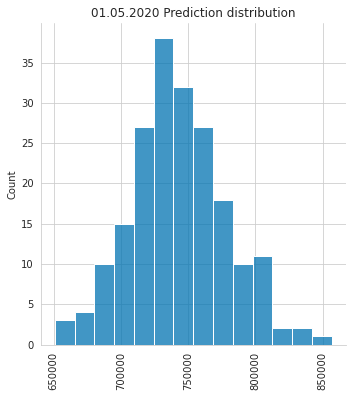

In [28]:
sns.displot(res[:, 0]);
plt.xticks(rotation=90);
plt.title("01.05.2020 Prediction distribution");

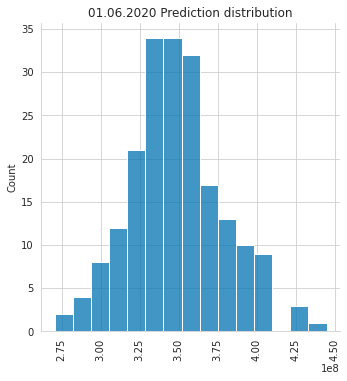

In [29]:
sns.displot(res[:, 1]);
plt.xticks(rotation=90);
plt.title("01.06.2020 Prediction distribution");

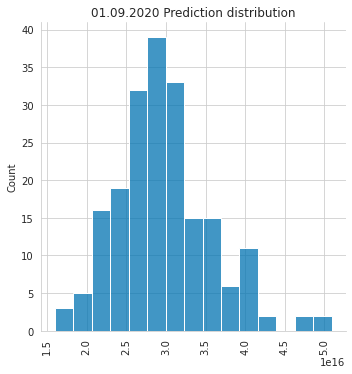

In [30]:
sns.displot(res[:, 2]);
plt.xticks(rotation=90);
plt.title("01.09.2020 Prediction distribution");

In [31]:
# предсказание на 1 мая
print(f"median {round(np.quantile(res[:, 0], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, 0], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, 0], 0.9))}")
print(f"True value: {test_df[test_df['x'] == MAY_FIRST]['total_cases'].iloc[0]}")

median 740134
10 quantile 699184
90 quantile 790678
True value: 114431.0


In [32]:
# предсказание на 1 июня
print(f"median {round(np.quantile(res[:, 1], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, 1], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, 1], 0.9))}")
print(f"True value: {test_df[test_df['x'] == JUNE_FIRST]['total_cases'].iloc[0]}")

median 347117160
10 quantile 312724045
90 quantile 389956425
True value: 414328.0


In [33]:
# предсказание на 1 сентября
print(f"median {round(np.quantile(res[:, 2], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, 2], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, 2], 0.9))}")
print(f"True value: {test_df[test_df['x'] == SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

median 29062595388849992
10 quantile 22529256215637412
90 quantile 38563632694929432
True value: 997072.0


## Часть 2.3

Предсказания экспоненциальной модели наверняка получились грустными. 

Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. 

Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. 

В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$\large{\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{t^2}{2}} \,dt}$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

### Часть 2.3.a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Наше предположение:

$$\large{y = k \int_{-\infty}^{x} e^{at^2 + bt + c} \,dt} = \int_{-\infty}^{x} e^{\log{k}}e^{at^2 + bt + c} \,dt = \int_{-\infty}^{x} e^{at^2 + bt + c_{new}} \,dt$$

Поскольку мы предсказываем от нулевого дня и наши предсказания дискретны, тогда:

$$\large{y_i = \sum_{t=0}^{x_i} e^{at^2 + bt + c_{new}}}$$

$$\large{y_i - \sum_{t=0}^{x_{i-1}} e^{at^2 + bt + c_{new}} = e^{ax^2 + bx + c_{new}}}$$

$$\large{y_i - y_{i-1} = e^{ax^2 + bx + c_{new}}}$$

$$\large{\log{(y_i - y_{i-1})} = ax^2 + bx + c_{new}}$$

Будем обучать модель с признаками номер дня и квадрат номера дня, предсказывать логарифм разности текущего и предыдущего значения целевой переменной

In [34]:
est = LinearRegression()
x = np.column_stack([train_df["x"], train_df["x"] ** 2])
y = train_df["new_cases"]
y.clip(lower=1, inplace=True)
y = np.log(y).values
est.fit(x, y)

LinearRegression()

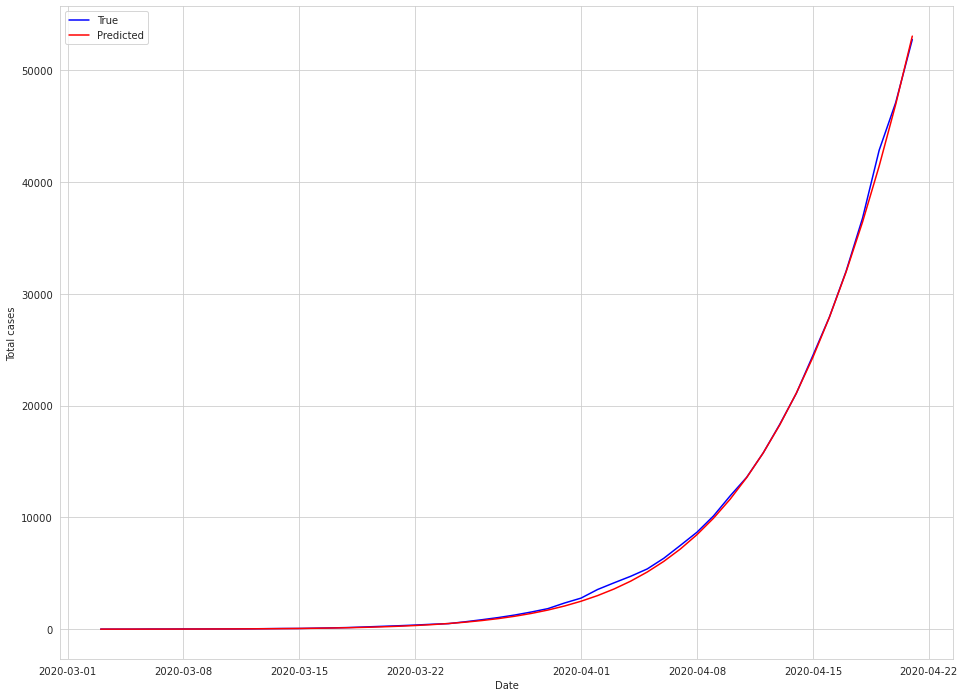

In [35]:
pred = est.predict(x)

plt.figure(figsize=(16, 12));
plt.plot(
    train_df["date"], 
    train_df["y"],
    color="b",
    label="True"
);
plt.plot(
    train_df["date"], 
    np.exp(pred).cumsum(), 
    color="r",
    label="Predicted"
);
plt.legend(loc="best");
plt.grid(True);
plt.xlabel("Date");
plt.ylabel("Total cases");

### Часть 2.3.b

Обучите эти параметры на датасете случаев коронавируса в России. 

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения.

Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

Натренеруем гребневую регрессию и оценим:

Оценим дисперсию шума данных

$$\large{\sigma^2 = \frac{1}{N} \sum_{n=1}^{N} (y_n - w^T\Phi(x_n))^2}$$


In [36]:
pred = est.predict(x)
sigma_noise = np.mean((y - pred)**2)

Посчитаем параметры апостреирного распредления весов модели

$$\large{\mu_N = \Sigma_N (\Sigma_0^{-1}\mu_0 + \frac{1}{\sigma^2}\Phi^Tt)}$$
$$\large{\Sigma_N = (\Sigma_0^{-1} + \frac{1}{\sigma^2}\Phi^T\Phi)^{-1}}$$

In [37]:
x_matrix = np.column_stack([np.ones_like(train_df["x"]), x])

mu, sigma = bayesian_update(
    np.zeros(3),
    10**3 * np.eye(3), 
    x_matrix,
    y, 
    sigma_noise
)

In [38]:
print(f"Mean of W:\n{mu}")
print(f"Variance of W:\n{sigma}")

Mean of W:
[-0.39658641  0.2756225  -0.00182979]
Variance of W:
[[ 9.52394107e-03 -7.69480531e-04  1.29542176e-05]
 [-7.69480531e-04  8.48437326e-05 -1.61928267e-06]
 [ 1.29542176e-05 -1.61928267e-06  3.30466208e-08]]


### Часть 2.3.c

Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. 

Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? 

Постройте эмпирическое предсказательное распределение, нарисуйте графики. 

Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [39]:
n_samples = 200
w = np.random.multivariate_normal(mu, sigma, n_samples)

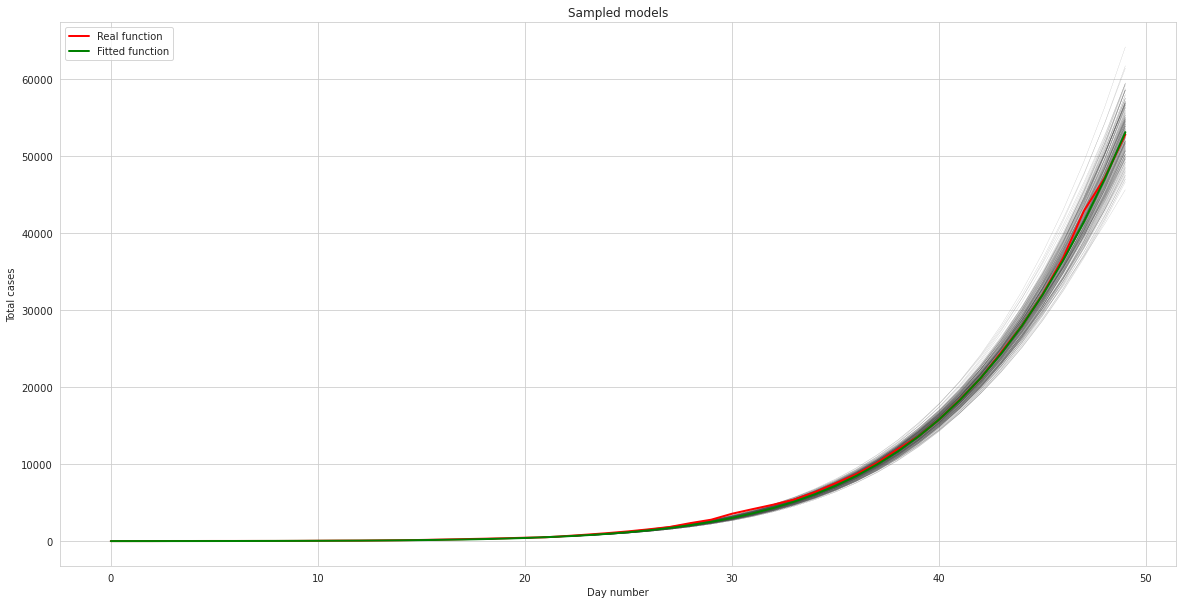

In [40]:
plt.figure(figsize=(20, 10));
for i in range(n_samples):
    plt.plot(train_df["x"], np.exp(w[i].dot(x_matrix.T)).cumsum(), linewidth=.1, color="0.3");
plt.plot(train_df["x"], train_df["y"], label="Real function", c="r", linewidth=2);
plt.plot(train_df["x"], np.exp(pred).cumsum(), label="Fitted function", c="g", linewidth=2);
plt.xlabel("Day number");
plt.ylabel("Total cases");
plt.title("Sampled models");
plt.legend(loc="best");

In [41]:
x = np.arange(SEPTEMBER_FIRST + 1)

pred_matrix = np.column_stack([np.ones(x.shape[0]), x, x**2])

res = np.exp(w.dot(pred_matrix.T)).cumsum(1)

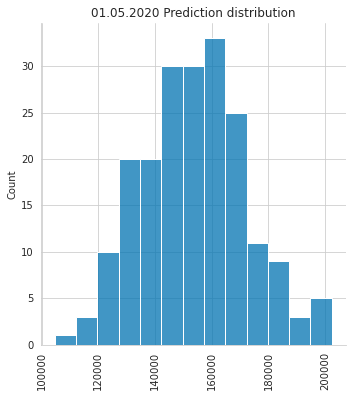

In [42]:
sns.displot(res[:, MAY_FIRST]);
plt.xticks(rotation=90);
plt.title("01.05.2020 Prediction distribution");

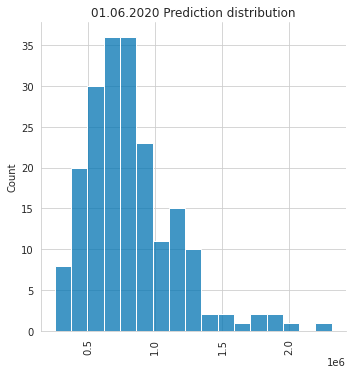

In [43]:
sns.displot(res[:, JUNE_FIRST]);
plt.xticks(rotation=90);
plt.title("01.06.2020 Prediction distribution");

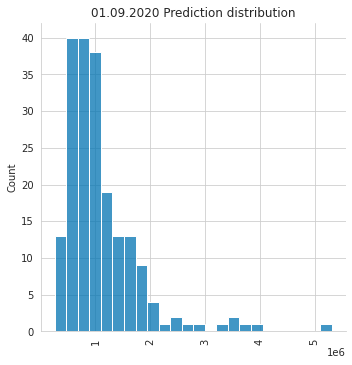

In [44]:
sns.displot(res[:, SEPTEMBER_FIRST]);
plt.xticks(rotation=90);
plt.title("01.09.2020 Prediction distribution");

In [45]:
# предсказание на 1 мая
print(f"median {round(np.quantile(res[:, MAY_FIRST], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, MAY_FIRST], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, MAY_FIRST], 0.9))}")
print(f"True value: {test_df[test_df['x'] == MAY_FIRST]['total_cases'].iloc[0]}")

median 152549
10 quantile 131539
90 quantile 178407
True value: 114431.0


In [46]:
# предсказание на 1 июня
print(f"median {round(np.quantile(res[:, JUNE_FIRST], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, JUNE_FIRST], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, JUNE_FIRST], 0.9))}")
print(f"True value: {test_df[test_df['x'] == JUNE_FIRST]['total_cases'].iloc[0]}")

median 762088
10 quantile 479326
90 quantile 1231995
True value: 414328.0


In [47]:
# предсказание на 1 сентября
print(f"median {round(np.quantile(res[:, SEPTEMBER_FIRST], 0.5))}")
print(f"10 quantile {round(np.quantile(res[:, SEPTEMBER_FIRST], 0.1))}")
print(f"90 quantile {round(np.quantile(res[:, SEPTEMBER_FIRST], 0.9))}")
print(f"True value: {test_df[test_df['x'] == SEPTEMBER_FIRST]['total_cases'].iloc[0]}")

median 932175
10 quantile 533027
90 quantile 1780132
True value: 997072.0


## Часть 2.4

проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). 

Насколько разные параметры получаются?

Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [48]:
countries = {
    'United Kingdom': -25,
    'India': -2,
    'Iran': -13,
    'Germany': -8,
    'Bolivia': 14,
    'Brazil': 0,
    'Israel': -3,
    'Japan': -34,
    'Canada': -9,
    'Sweden': -5,
    'United Arab Emirates': -11,
    'Saudi Arabia': 4,
    'Serbia': 6,
    'Italy': -12,
    'Romania': 4,
    'Peru': 4,
    'Spain': -8,
    'Mexico': 7
}

In [49]:
N = 50
countries_mean = {}
countries_variance = {}
countries_est = {}

for country, v in countries.items():
    est = LinearRegression()
    train_df = df[(df["location"] == country) & (df["x"] >= v)].reset_index(drop=True).iloc[:N]
    train_df["x"] = train_df.index
    x = np.column_stack([train_df["x"], train_df["x"] ** 2])
    y = train_df["new_cases"]
    y.clip(lower=1, inplace=True)
    y = np.log(y).values
    est.fit(x, y)
    pred = est.predict(x)
    
    
    sigma_noise = np.mean((y - pred)**2)
    x_matrix = np.column_stack([np.ones_like(train_df["x"]), x])
    
    mu, sigma = bayesian_update(
        np.zeros(3),
        np.eye(3), 
        x_matrix,
        y, 
        sigma_noise
    )
    
    countries_mean[country] = mu
    countries_variance[country] = sigma
    countries_est[country] = est

In [50]:
weights = pd.DataFrame(countries_mean).T

In [51]:
weights.describe()

,0,1,2
count,18.000000,18.000000,18.000000
mean,0.542934,0.254428,-0.002607
std,0.851429,0.122265,0.002489
min,-0.832059,-0.021758,-0.006207
25%,-0.028455,0.203307,-0.004468
50%,0.464719,0.253284,-0.002752
75%,0.930477,0.344760,-0.001242
max,2.622601,0.452121,0.003065


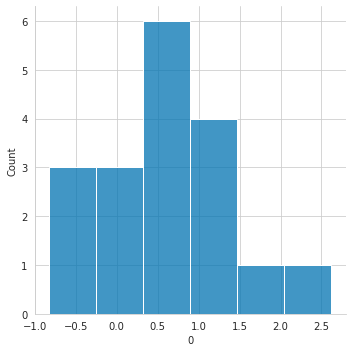

In [52]:
sns.displot(weights[0]);

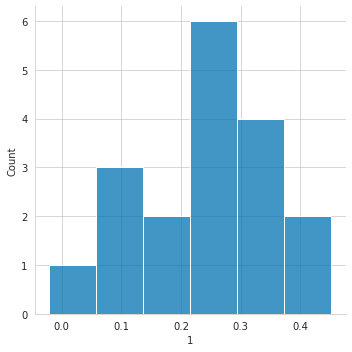

In [53]:
sns.displot(weights[1]);

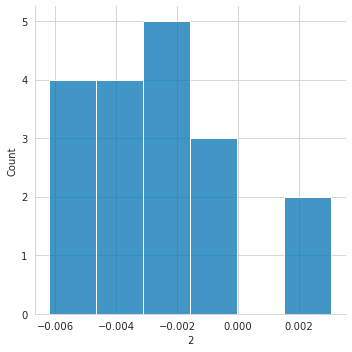

In [54]:
sns.displot(weights[2]);

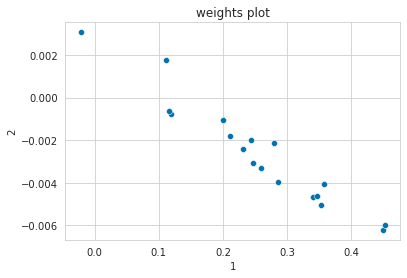

In [55]:
sns.scatterplot(x=weights[1], y=weights[2]);
plt.title("weights plot");

Примерно половина весов лежат близко к друг другу, однако встречаются и удаленные точки - можно сделать вывод что параметры достаточно отличаются, однако

Мы наблюдаем линейную зависимость между весами модели отвечающими за 1 и 2 степень

Поскольку зависимость между весами линейная уменьшим размерность до 2х чтобы посмотреть на кластера данных

In [56]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=2))

In [57]:
visual = pipe.fit_transform(weights)

In [58]:
# мы получаем хорошее двумерное представление данных
pipe.steps[1][1].explained_variance_ratio_.sum()

0.9925927793826899

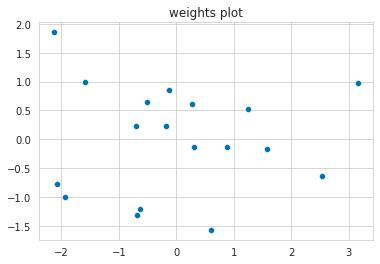

In [59]:
sns.scatterplot(x=visual[:, 0], y=visual[:, 1]);
plt.title("weights plot");

Данные по весам распределенны равномерно по графику, ярко выделенных кластеров не наблюдается

## Часть 2.5

Что вы поняли из этого упражнения? - что доменные знания о наблюдаемых величинах крайне важны, поскольку позволяют точнее моделировать зависимости

Что можно сказать про коронавирус по итогам такого моделирования? - Данный вирус является крайне опасным поскольку в кратчайшие сроки может перегрузить медицинскую систему

Как принять решение, например, о том, нужно ли вводить карантин? - для принятия решения о необходимости введения карантина нужно определеть фазу на которой находится эпидемия в данный момент и если это фаза быстрого роста, то карантин необходим чтобы превратить около экспонентоциальный рост в линейный